In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load Plant 1
plant1_gen = pd.read_csv('Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [ ]:
# Merge datasets ('DATE_TIME' is a common key)
plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'])
plant1 = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME', suffixes=('_gen', '_weather'))

# Feature engineering
plant1['hour'] = plant1['DATE_TIME'].dt.hour
plant1['day'] = plant1['DATE_TIME'].dt.day
plant1['month'] = plant1['DATE_TIME'].dt.month
plant1['year'] = plant1['DATE_TIME'].dt.year

features = ['hour', 'day', 'month', 'year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'AC_POWER'

# Drop rows
train_data = plant1.dropna(subset=[target])

# Fill missing feature vals
train_data = train_data.fillna(method='ffill')

<ipython-input-9-a3e793a487f5>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plant1_gen['DATE_TIME'] = pd.to_datetime(plant1_gen['DATE_TIME'])


In [ ]:
# Split training/testing
X = train_data[features]
y = train_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model
rf_model = RandomForestRegressor(random_state=42)

# Train with cross-validation & evaluate
model_name = 'Random Forest'
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"{model_name} - Cross-validated RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

Random Forest - Cross-validated RMSE: 48.44 (+/- 3.70)


In [ ]:
# Hyperparameter grids for tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Hyperparameter tuning using RandomizedSearchCV
def tune_model(model, param_grid, X_train, y_train):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42, verbose=2)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

# Tune model
rf_best_model = tune_model(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# Evaluate on training and testing sets
def evaluate_model_on_train_test(model_name, model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    print(f"{model_name} - Training MAE: {train_mae:.2f}, Testing MAE: {test_mae:.2f}")
    print(f"{model_name} - Training RMSE: {train_rmse:.2f}, Testing RMSE: {test_rmse:.2f}")
    print(f"{model_name} - Training R2: {train_r2:.2f}, Testing R2: {test_r2:.2f}")

# Evaluate
evaluate_model_on_train_test("Tuned Random Forest", rf_best_model, X_train, y_train, X_test, y_test)

Tuned Random Forest - Training MAE: 15.53, Testing MAE: 16.37
Tuned Random Forest - Training RMSE: 45.21, Testing RMSE: 45.59
Tuned Random Forest - Training R2: 0.99, Testing R2: 0.99


In [ ]:
# Creating lag features
for lag in range(1, 4):
    plant1[f'lag_{lag}'] = plant1['AC_POWER'].shift(lag)

# Creating rolling statistics
plant1['rolling_mean'] = plant1['AC_POWER'].rolling(window=3).mean()
plant1['rolling_std'] = plant1['AC_POWER'].rolling(window=3).std()

# Drop rows with NaN values generated by shifting
plant1 = plant1.dropna()

# Define the new feature set
features = ['hour', 'day', 'month', 'year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
            'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']

# Redefine target
target = 'AC_POWER'

In [ ]:
# Split data into training and testing sets
X = plant1[features]
y = plant1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tune the best model with new features
rf_best_model = tune_model(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train)

# Evaluate the best model with new features
evaluate_model_on_train_test("Tuned Random Forest with New Features", rf_best_model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned Random Forest with New Features - Training MAE: 1.82, Testing MAE: 4.40
Tuned Random Forest with New Features - Training RMSE: 8.35, Testing RMSE: 19.41
Tuned Random Forest with New Features - Training R2: 1.00, Testing R2: 1.00


In [ ]:
# Define the meta-model
meta_model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)

# Create the stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_best_model),
        ('lasso', Lasso(alpha=0.1)),
        ('ridge', Ridge(alpha=1.0)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42))
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Evaluate the stacking ensemble
stacking_preds = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, stacking_preds)
rmse_stacking = np.sqrt(mean_squared_error(y_test, stacking_preds))
r2_stacking = r2_score(y_test, stacking_preds)
print(f"Stacking Ensemble - MAE: {mae_stacking:.2f}, RMSE: {rmse_stacking:.2f}, R2: {r2_stacking:.2f}")

Stacking Ensemble - MAE: 5.31, RMSE: 9.06, R2: 1.00


In [ ]:
evaluate_model_on_train_test("Stacking Ensemble", stacking_model, X_train, y_train, X_test, y_test)

Stacking Ensemble - Training MAE: 5.30, Testing MAE: 5.31
Stacking Ensemble - Training RMSE: 8.91, Testing RMSE: 9.06
Stacking Ensemble - Training R2: 1.00, Testing R2: 1.00


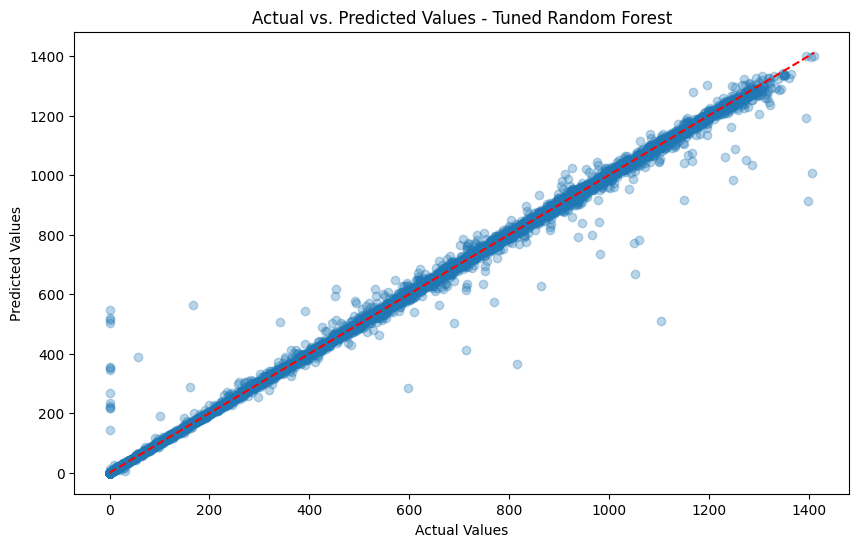

In [ ]:
# Plot actual vs predicted values
def plot_actual_vs_predicted(model_name, model, X_test, y_test):
    preds = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.show()

plot_actual_vs_predicted("Tuned Random Forest", rf_best_model, X_test, y_test)

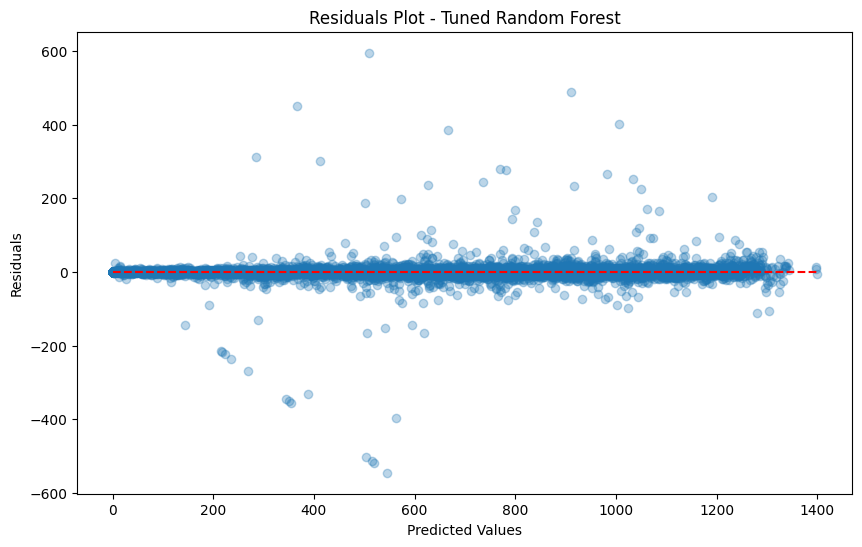

In [ ]:
# Plot residuals
def plot_residuals(model_name, model, X_test, y_test):
    preds = model.predict(X_test)
    residuals = y_test - preds
    plt.figure(figsize=(10, 6))
    plt.scatter(preds, residuals, alpha=0.3)
    plt.hlines(y=0, xmin=preds.min(), xmax=preds.max(), colors='r', linestyles='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot - {model_name}')
    plt.show()

plot_residuals("Tuned Random Forest", rf_best_model, X_test, y_test)